# Replication Exercise: Armed groups

Contributors: 
[Dominik Bursy](mailto:dominik.bursy@icloud.com)

Last Update: March 2024

---

The objective of this notebook is to perform a limited replication study of the following research paper:

Gassebner, Martin & Schaudt, Paul & Wong, Melvin H.L., 2023. "Armed groups: Competition and political violence," Journal of Development Economics, Elsevier, vol. 162(C).

---

## Table of Contents

- [Import Packages & Set Root Directory](#packages)
- [Import Datasets](#dataset)
    - [Pakistan - Subnational Administrative Boundaries](#pakistan)
    - [Global Terrorism Database (GTD)](#gdt)
    - [UCDP Georeferenced Event Dataset (GED)](#ged)
- [Data Preparation](#preparation)
    - [Data Preparation GTD](#preparation_gtd)
        - [Subset Dataframe and Spatially Join Pakistan Boundaries](#preparation_gtd_subset)
        - [Create Dependent Variables: Incidents and Casualties](#preparation_gtd_incidents)
        - [Create Independent Variable: Armed Group](#preparation_gtd_groups)
    - [Data Preparation GED](#preparation_ged)
    - [Combine GTD and GED](#preparation_combination)
- [Descriptive Statistics and Figures](#descriptives)
    - [Figure A-1](#figure_a1)
    - [Figure A-7](#figure_a7)
    - [Figure A-8](#figure_a8)
    - [Figure 2](#figure_2)
    - [Figure 3](#figure_3)
- [Next Steps](#next_steps)

---

## Import Packages & Set Root Directory <a class="anchor" id="packages"></a>

In [33]:
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import lines

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

savefigures = True

In [34]:
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/ozgltcj/Documents/replication_schaudt


---

## Import Dataset <a class="anchor" id="dataset"></a>

- [Humanitarian Data Exchange (HDX): Pakistan - Subnational Administrative Boundaries](https://data.humdata.org/dataset/cod-ab-pak?)
- [Global Terrorism Database (GTD)](https://www.start.umd.edu/gtd/)
- [UCDP Georeferenced Event Dataset (GED)](https://ucdp.uu.se/downloads/)

### Pakistan - Subnational Administrative Boundaries <a class="anchor" id="pakistan"></a>


In [35]:
gdf_pakistan = gpd.read_file(f'{ROOT_FOLDER}/data/pak_adm_wfp_20220909_shp/pak_admbnda_adm2_wfp_20220909.shp')
#gdf_pakistan.plot(facecolor='lightgrey', edgecolor="black", linewidth=1)

### Global Terrorism Database (GTD) <a class="anchor" id="gdt"></a>

In [36]:
df_gtd = pd.read_excel(f'{ROOT_FOLDER}/data/gtd/globalterrorismdb_0522dist.xlsx')

### UCDP Georeferenced Event Dataset (GED) <a class="anchor" id="ged"></a>

In [37]:
df_ged = pd.read_csv(f'{ROOT_FOLDER}/data/ged/GEDEvent_v23_1.csv', low_memory=False)

---

## Data Preparation <a class="anchor" id="preparation"></a>

### Data Preparation GTD <a class="anchor" id="preparation_gtd"></a>

- Dependent variable: Organized political violence
    - Number of incidents
    - Number of casualties (sum of people wounded and killed): nwound, nkill
- Independent variable: 
    - Number of armed groups: gname, gname2, gname3

#### Subset Dataframe and Spatially Join Pakistan Boundaries <a class="anchor" id="preparation_gtd_subset"></a>

In [39]:
## Conditions
condition_country = (df_gtd['country_txt'] == 'Pakistan') # -> Year Condition
condition_year = (df_gtd['iyear'] >= 1995) & (df_gtd['iyear'] <= 2018) # -> Year Condition
condition_type = df_gtd['attacktype1'].isin([1,2,3,4,5,6,7,8,9]) # -> Method of attack 

## Subset dataframe
df_gtd_sub = df_gtd[condition_country & condition_year & condition_type].dropna(
    subset=['longitude', 'latitude']).copy(deep=True).reset_index(drop=True)

## Create geodataframe
gdf_gtd = gpd.GeoDataFrame(
    df_gtd_sub, geometry=gpd.points_from_xy(df_gtd_sub['longitude'], df_gtd_sub['latitude'])
)
gdf_gtd.crs = 'epsg:4326'

## Spatial join with Pakistan boundaries
gdf_gtd_merged = gpd.sjoin(gdf_pakistan[['ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'geometry']], gdf_gtd, how='left')

print('Number of observations:', gdf_gtd.shape[0])
print('Missing values longitude:', gdf_gtd.loc[condition_country & condition_year & condition_type, ['longitude']].isna().sum()[0])
print('Missing values latitude:', gdf_gtd.loc[condition_country & condition_year & condition_type, ['latitude']].isna().sum()[0])

Number of observations: 14122
Missing values longitude: 0
Missing values latitude: 0


#### Create Dependent Variables: Incidents and Casualties <a class="anchor" id="preparation_gtd_incidents"></a>

In [40]:
## Create variables
gdf_gtd_merged['casualties'] = gdf_gtd_merged[['nkill', 'nwound']].sum(axis=1)
gdf_gtd_merged['incidents'] = 1

## Subset and balance dataframe
gdf_gtd_merged_grouped = gdf_gtd_merged.groupby(['ADM2_EN', 'iyear'])[['incidents', 'casualties']].sum()
index = pd.MultiIndex.from_product(gdf_gtd_merged_grouped.index.levels)
gdf_gtd_merged_grouped = gdf_gtd_merged_grouped.reindex(index).fillna(0).reset_index()

## Add geometry and create geodataframe
gdf_gtd_merged_grouped = gdf_gtd_merged_grouped.merge(
    gdf_gtd_merged[['ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'geometry']].drop_duplicates(), 
    on='ADM2_EN', how='left'
)
gdf_merged_grouped = gpd.GeoDataFrame(gdf_gtd_merged_grouped, crs="EPSG:4326", geometry=gdf_gtd_merged_grouped.geometry)

#### Create Independent Variable: Armed Groups <a class="anchor" id="preparation_gtd_groups"></a>

In [41]:
## Match group names

group_dict = {
    "Aalmi Majlis-i-Tahfuz-i-Khatam-i-Nubuwaat": "Aalmi Majlis Tahaffuz Khatm-e-Nubuwwat", # --> Not included in Appendix
    "Abdullah Azzam Brigades": "Abdullah Azzam Brigades",
    "Abu Hafs Katibatul al-Ghurba al-Mujahideen": "Abu Hafs Katibatul al-Ghurba al- Mujahideen",
    "Afghans": "NA",
    "Afridi Tribe": "NA", # --> Not included in Appendix
    "Ahle Sunnat Wal Jamaat (ASWJ-Pakistan)": "ASWJ",
    "Al-Intiqami al-Pakistani": "Al-Intiqami al-Pakistani",
    "Al-Jihad (Pakistan)": "Al-Jihad", # --> Not included in Appendix
    "Al-Mansoorian": "Al-Mansoorian",
    "Al-Nawaz": "Al-Nawaz", # --> Not included in Appendix
    "Al-Qaida": "Al-Qaida",
    "Al-Qaida in the Indian Subcontinent": "Al-Qaida",
    "Amr Bil Maroof Wa Nahi Anil Munkir": "Amr Bil Maroof Wa Nahi Anil Munkir",
    "Ansar Al-Mujahideen (Pakistan)": "Ansar Al-Mujahideen",
    "Ansar Wa Mohajir (Pakistan)": "Ansar Wa Mohajir",
    "Ansar al-Sharia (Pakistan)": "Ansar al-Sharia",
    "Ansarul Islam (Pakistan)": "Ansaar ul-Islam",
    "Anti-Bhutto demonstrators": "NA", # --> Not included in Appendix
    "Baba Ladla Gang": "Baba Ladla Gang",
    "Baloch Liberation Army (BLA)": "BLA",
    "Baloch Liberation Front (BLF)": "BLF",
    "Baloch Liberation Tigers (BLT)": "BLT",
    "Baloch Militant Defense Army": "Baloch Militant Defense Army",
    "Baloch Mussalah Diffah Tanzim (BMDT)": "BMDT",
    "Baloch National Liberation Front": "Baloch National Liberation Front",
    "Baloch Nationalists": "NA",
    "Baloch Republican Army (BRA)": "BRA",
    "Baloch Republican Guards (BRG)": "BRG",
    "Baloch Republican Party": "BRA",
    "Baloch Waja Liberation Army (BWLA)": "BWLA",
    "Baloch Young Tigers (BYT)": "BYT",
    "Balochistan Liberation United Front (BLUF)": "BLUF",
    "Balochistan National Army": "NA", # --> Not included in Appendix
    "Bandits": "NA",
    "Bhittani tribe": "NA",
    "Brelvi Muslims": "NA",
    "Dacoits": "NA", # --> Not included in Appendix
    "Egyptian Islamic Jihad (Al-Jihad)": "Al-Jihad", # --> Not included in Appendix
    "Fedayeen Imam Mahdi": "NA", # --> Not included in Appendix
    "Former Student Hostel": "NA", # --> Not included in Appendix
    "Free Balochistan Army (FBA)": "Free Balochistan Army (FBA)",
    "Gunmen": "NA",
    "Hafeez Brohi Group": "Hafeez Brohi Group",
    "Hafiz Gul Bahadur Group": "Hafiz Gul Bahadur Group",
    "Halqa-e-Mehsud": "Halqa-e-Mehsud",
    "Haqqani Network": "Haqqani Network",
    "Harakat ul-Mujahidin (HuM)": "Harakat ul-Mujahidin (HuM)",
    "Harakat ul-Mujahidin Al-Almi": "Harakat ul-Mujahidin Al-Almi",
    "Harkatul Jihad-e-Islami": "Harkatul Jihad-e-Islami",
    "Hizb al-Tahrir al-Islami (HT)": "Hizb al-Tahrir al-Islami (HT)", # --> Not included in Appendix
    "Hizb-ul-Ahrar (HuA)": "Hizb-ul-Ahrar (HuA)", # --> Not included in Appendix
    "Islambouli Brigades of al-Qaida": "Al-Qaida", # --> Not included in Appendix
    "Islami Jamiat-e-Talaba (IJT)": "IJT",
    "Islamic Movement of Uzbekistan (IMU)": "IMU",
    "Jaish Usama": "Jaish Usama",
    "Jaish al-Umar (JaU)": "Jaish al-Umar (JaU)",
    "Jaish as-Saiyouf (Army of Swords)": "Jaish as-Saiyouf (Army of Swords)",
    "Jaish-e-Islam": "Jaish-e-Islam",
    "Jaish-e-Khorasan (JeK)": "JeK",
    "Jaish-e-Mohammad (JeM)": "JeM",
    "Jamaat-E-Islami (India/Pakistan)": "Jamaat-E-Islami",
    "Jamaat-ul-Ahrar": "Jamaat-ul-Ahrar",
    "Jeay Sindh Muttahida Mahaz (JSMM)": "Jeay Sindh Muttahida Mahaz (JSMM)", # --> Not included in Appendix
    "Jeay Sindh Qaumi Mahaz (JSQM)": "Jeay Sindh Qaumi Mahaz (JSQM)",
    "Jundallah (Pakistan)": "Jondullah",
    "Kaka-Tribesmen": "NA", # --> Not included in Appendix
    "Kalpar Tribesmen": "NA",
    "Khatm-e-Nabuwat (KeN)": "Khatm-e-Nabuwat (KeN)",
    "Khorasan Chapter of the Islamic State": "IS",
    "Lashkar-e-Balochistan": "",
    "Lashkar-e-Islam (Pakistan)": "",
    "Lashkar-e-Jarrar": "",
    "Lashkar-e-Jhangvi": "",
    "Lashkar-e-Omar": "",
    "Lashkar-e-Taiba (LeT)": "",
    "Local landlord employee": "NA", # --> Not included in Appendix
    "Mahsud Tribe": "NA",
    "Majlis-e-Askari": "Majlis-e-Askari",
    "Majlis-e-Lashkari": "Majlis-e-Lashkari",
    "Mazari Tribesmen": "NA", # --> Not included in Appendix
    "Militants": "NA",
    "Miscreants": "NA",
    "Mohajir National Movement": "MQM",
    "Mujahideen Ansar": "Mujahideen Ansar",
    "Mullah Nazir Group": "Mullah Nazir Group", # --> Not included in Appendix
    "Muslim Fundamentalists": "NA",
    "Muslim Militants": "NA",
    "Muslim United Army (MUA)": "MUA", # --> Not included in Appendix
    "Muslim extremists": "NA",
    "Mutahida Majlis-e-Amal": "Mutahida Majlis-e-Amal",
    "Muttahida Qami Movement (MQM)": "MQM",
    "New People's Army (NPA)": "NA",
    "Orakzai Freedom Movement": "NA",
    "Pakistan Muslim League (PML)": "NA", # --> Not included in Appendix
    "Pakistani People's Party (PPP)": "Pakistani People's Party (PPP)",
    "People's Amn Committee": "People's Aman Committee",
    "Political Activists": "NA",
    "Punjabi Taliban": "Taliban",
    "Qari Kamran Group": "Qari Kamran Group",
    "Rival Afghan Group": "NA", # --> Not included in Appendix
    "Separatists": "NA",
    "Shia Muslim extremists": "NA",
    "Sindh Liberation Front": "Sindh Liberation Front",
    "Sindhu Desh Liberation Army (SDLA)": "Sindhu Desh Liberation Army (SDLA)",
    "Sindhudesh Revolutionary Army (SRA)": "Sindhudesh Revolutionary Army (SRA)",
    "Sipah-I-Mohammed": "Sipah-I-Mohammed",
    "Sipah-e-Sahaba/Pakistan (SSP)": "ASWJ",
    "Sunni Muslim extremists": "NA",
    "Taliban": "Taliban",
    "Taliban (Pakistan)": "Taliban",
    "Tanzeem Ittehad - I - Ulema Qabail (Tiuq)Tribesmen": "NA", # --> Not included in Appendix
    "Tanzeem al-Islami al-Furqan": "Tanzeem al-Islami al-Furqan",
    "Tawheedul Islam": "Tawheed ul-Islam",
    "Tehreek-e-Labbaik Pakistan (TLP)": "Tehreek-e-Labbaik Pakistan (TLP)", # --> Not included in Appendix
    "Tehrik-e-Khilafat": "Tehrik-e-Khilafat",
    "Tehrik-e-Nafaz-e-Shariat-e-Mohammadi (TNSM)": "TNSM",
    "Tehrik-e-Nifaz-e-Aman Balochistan-Jhalawan Brigade (TNAB-Jhalawan Brigade)": "TNAB-Jhalawan Brigade",
    "Tehrik-e-Taliban Islami (TTI)": "Tehrik-e-Taliban Islami (TTI)",
    "Tehrik-e-Tuhafaz (Pakistan)": "Tehrik-e-Tuhafaz",
    "Tehrik-i-Taliban Pakistan (TTP)": "Taliban",
    "Tribal Group": "NA",
    "Tribesmen": "NA",
    "Ujjan Tribe": "NA", # --> Not included in Appendix
    "United Baloch Army (UBA)": "UBA",
    "Unknown": "NA",
    "Uzair Baloch Gang": "Uzair Baloch Gang",
    "Youths": "NA",
    "Zehri Youth Force (ZYF)": "Zehri Youth Force (ZYF)"
}

for key, value in group_dict.items():
    gdf_gtd_merged.loc[
        gdf_gtd_merged['gname'] == key, 'gname_matched'] = value
    gdf_gtd_merged.loc[
        gdf_gtd_merged['gname2'] == key, 'gname2_matched'] = value
    gdf_gtd_merged.loc[
        gdf_gtd_merged['gname3'] == key, 'gname3_matched'] = value

print(
    'Test for duplicated group names:',
    (gdf_gtd_merged.gname == gdf_gtd_merged.gname2).sum(),
    (gdf_gtd_merged.gname2 == gdf_gtd_merged.gname3).sum(), 
    (gdf_gtd_merged.gname == gdf_gtd_merged.gname3).sum()
)

Test for duplicated group names: 0 0 0


In [42]:
## District-Year dataframe with armed groups
df_gtd_armed_groups = pd.concat([
    pd.DataFrame(
        gdf_gtd_merged[['ADM2_EN', 'iyear', 'gname_matched']].dropna().groupby(['ADM2_EN', 'iyear'])['gname_matched'].apply(list)
    ),
    pd.DataFrame(
        gdf_gtd_merged[['ADM2_EN', 'iyear', 'gname2_matched']].dropna().groupby(['ADM2_EN', 'iyear'])['gname2_matched'].apply(list)
    ),
    pd.DataFrame(
        gdf_gtd_merged[['ADM2_EN', 'iyear', 'gname3_matched']].dropna().groupby(['ADM2_EN', 'iyear'])['gname3_matched'].apply(list)
    )
],axis=1)

## Fill missing values
df_gtd_armed_groups['gname_matched'] = df_gtd_armed_groups['gname_matched'].fillna("").apply(list)
df_gtd_armed_groups['gname2_matched'] = df_gtd_armed_groups['gname2_matched'].fillna("").apply(list)
df_gtd_armed_groups['gname3_matched'] = df_gtd_armed_groups['gname3_matched'].fillna("").apply(list)

## Combine all involved groups
def combine_values(a,b,c):
    return list(set(filter(lambda x: x == x, a + b + c)))

df_gtd_armed_groups['groups_matched'] = df_gtd_armed_groups.apply(
    lambda row: combine_values(row['gname_matched'], row['gname2_matched'], row['gname3_matched']), axis=1
)

## Balance dataframe
#index = pd.MultiIndex.from_product(df_gtd_armed_groups.index.levels)
#df_gtd_armed_groups = df_gtd_armed_groups[['groups_matched']].reindex(index)

In [43]:
## Merge with grouped dataframe
gdf_gtd_final = gdf_merged_grouped.set_index(['ADM2_EN', 'iyear'])[['ADM0_EN', 'ADM1_EN', 'geometry', 'casualties', 'incidents']].merge(
    df_gtd_armed_groups[['groups_matched']], left_index=True, right_index=True, how='left'
)

## Fill missing values
gdf_gtd_final['groups_matched'] = gdf_gtd_final['groups_matched'].fillna("").apply(list)

## Calculate number of activate groups
gdf_gtd_final['number_groups'] = gdf_gtd_final['groups_matched'].apply(len)

### Data Preparation GED <a class="anchor" id="preparation_ged"></a>

- Dependent variable: Organized political violence
    - Number of incidents
    - Number of casualties (sum of people wounded and killed): best
- Independent variable: 
    - Number of armed groups: side_a, side_b

In [44]:
## Conditions
condition_country = (df_ged['country'] == 'Pakistan') # -> Year Condition
condition_year = (df_ged['year'] >= 1995) & (df_ged['year'] <= 2018) # -> Year Condition
condition_type = df_ged['type_of_violence'].isin([1,2,3]) # -> Method of attack 

## Subset dataframe --> subset longitude-latitude instead of adm_2
df_ged_sub = df_ged[condition_country & condition_year & condition_type].dropna(
    subset=['longitude', 'latitude']).copy(deep=True).reset_index(drop=True)

## Create geodataframe
gdf_ged = gpd.GeoDataFrame(
    df_ged_sub, geometry=gpd.points_from_xy(df_ged_sub['longitude'], df_ged_sub['latitude'])
)
gdf_ged.crs = 'epsg:4326'

## Spatial join with Pakistan boundaries
gdf_ged_merged = gpd.sjoin(gdf_pakistan[['ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'geometry']], gdf_ged, how='left')

print('Number of observations:', gdf_ged.shape[0])
print('Missing values longitude:', df_ged.loc[condition_country & condition_year & condition_type, ['longitude']].isna().sum()[0])
print('Missing values latitude:', df_ged.loc[condition_country & condition_year & condition_type, ['latitude']].isna().sum()[0])

Number of observations: 5936
Missing values longitude: 0
Missing values latitude: 0


In [45]:
## Create variables
gdf_ged_merged['casualties_ged'] = gdf_ged_merged[['best']].copy(deep=True)
gdf_ged_merged['incidents_ged'] = 1

## Subset and balance dataframe
gdf_ged_merged.rename(columns={'year': 'iyear'}, inplace=True)
gdf_ged_merged_grouped = gdf_ged_merged.groupby(['ADM2_EN', 'iyear'])[['casualties_ged', 'incidents_ged']].sum()
index = pd.MultiIndex.from_product(gdf_ged_merged_grouped.index.levels)
gdf_ged_merged_grouped = gdf_ged_merged_grouped.reindex(index).fillna(0).reset_index()

## Add geometry and create geodataframe
gdf_ged_merged_grouped = gdf_ged_merged_grouped.merge(
    gdf_gtd_merged[['ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'geometry']].drop_duplicates(), 
    on='ADM2_EN', how='left'
)
gdf_ged_merged_grouped = gpd.GeoDataFrame(gdf_ged_merged_grouped, crs="EPSG:4326", geometry=gdf_ged_merged_grouped.geometry)

In [46]:
## Match group names

group_dict = { # --> Not included in Appendix
    "Government of Pakistan": "Government of Pakistan",
    "Government of United States of America": "Government of United States of America",
    "TTP": "Taliban",
    "Government of India": "Government of India",
    "Lashkar-e-Islam": "Lashkar-e-Islam",
    "Government of Afghanistan": "Government of Afghanistan",
    "LeJ": "LeJ",
    "BLA": "BLA",
    "Bangesh": "NA",
    "Ansaar ul-Islam": "Ansaar ul-Islam",
    "MQM": "MQM",
    "Mangal": "NA",
    "IMU": "IMU",
    "TTP-KM": "TTP-KM",
    "IS": "IS",
    "Lashkar of Salarzai tribe": "NA",
    "Laskhar of Masozai Qaumi tribe": "NA",
    "Lashkar of Orakzai tribe": "NA",
    "Lashkar of Mohmand tribe": "NA",
    "TTP - MR": "TTP-MR",
    "Forces of Momin Afridi": "Forces of Momin Afridi",
    "Forces of Turkestan Bhittani": "Forces of Turkestan Bhittani",
    "UBA": "UBA",
    "Forces of Shah Sahib": "Forces of Shah Sahib",
    "Jaish-ul-Islam": "Jaish-ul-Islam",
    "Taleban": "Taliban",
    "Kachai sub-tribe of Bangesh": "NA",
    "Government of Iran": "Government of Iran",
    "Lashkar of Kukikhel clan": "NA",
    "Government of Iraq": "Government of Iraq",
    "TTP-Islahi": "TTP-Islahi",
    "Supporters of MQM": "NA",
    "al-Qaida": "Al-Qaida",
    "Jondullah": "Jondullah",
    "TTP": "Taliban",
    "Civilians": "NA",
    "al-Qaida": "Al-Qaida",
    "Government of Pakistan": "Government of Pakistan",
    "BLA": "BLA",
    "Lashkar-e-Islam": "Lashkar-e-Islam",
    "BRA": "BRA",
    "Taleban": "Taliban",
    "Turi": "NA",
    "Lashkar of Zakakhel tribe": "NA",
    "MQM-H": "MQM-H",
    "Tawheed ul-Islam": "Tawheed ul-Islam",
    "MQM": "MQM",
    "TTP - TA": "TTP-TA",
    "Lashkhar of Wazir tribe": "NA",
    "BLF": "BLF",
    "TTP-SM": "TTP-SM",
    "IS": "IS",
    "Lashkar of Akakhel tribe": "NA",
    "UBA": "UBA",
    "Mangal": "NA",
    "TTP - MT": "TTP-MT",
    "Baloch Ittehad": "Baloch Ittehad",
    "IMU": "IMU",
    "Jamaat-ul-Ahrar": "Jamaat-ul-Ahrar",
    "Mishti": "NA",
    "Hizb-i Islami-yi Afghanistan": "Hizb-i Islami-yi Afghanistan",
    "Jondullah": "Jondullah",
    "Supporters of PPP": "NA",
    "Jaish al-Adl": "NA", # --> Not included in Appendix
    "Kashmir insurgents": "NA"
}

for key, value in group_dict.items():
    gdf_ged_merged.loc[
        gdf_ged_merged['side_a'] == key, 'side_a_matched'] = value
    gdf_ged_merged.loc[
        gdf_ged_merged['side_b'] == key, 'side_b_matched'] = value

print(
    'Test for duplicated group names:',
    (gdf_ged_merged.side_a == gdf_ged_merged.side_b).sum()
)

#print(gdf_ged_merged.side_a.value_counts().sum())
#print(gdf_ged_merged.side_a_matched.value_counts().sum())

Test for duplicated group names: 0


In [47]:
## District-Year dataframe with armed groups
df_ged_armed_groups = pd.concat([
    pd.DataFrame(
        gdf_ged_merged[['ADM2_EN', 'iyear', 'side_a_matched']].dropna().groupby(['ADM2_EN', 'iyear'])['side_a_matched'].apply(list)
    ),
    pd.DataFrame(
        gdf_ged_merged[['ADM2_EN', 'iyear', 'side_b_matched']].dropna().groupby(['ADM2_EN', 'iyear'])['side_b_matched'].apply(list)
    )
],axis=1)

## Fill missing values
df_ged_armed_groups['side_a_matched'] = df_ged_armed_groups['side_a_matched'].fillna("").apply(list)
df_ged_armed_groups['side_b_matched'] = df_ged_armed_groups['side_b_matched'].fillna("").apply(list)

## Combine all involved groups
def combine_values(a,b):
    return list(set(filter(lambda x: x == x, a + b)))

df_ged_armed_groups['groups_matched_ged'] = df_ged_armed_groups.apply(
    lambda row: combine_values(row['side_a_matched'], row['side_b_matched']), axis=1
)

## Balance dataframe
#index = pd.MultiIndex.from_product(df_ged_armed_groups.index.levels)
#df_ged_armed_groups = df_ged_armed_groups[['groups_matched_ged']].reindex(index)

In [48]:
## Merge with grouped dataframe
gdf_ged_final = gdf_ged_merged_grouped.set_index(['ADM2_EN', 'iyear'])[['casualties_ged', 'incidents_ged']].merge(
    df_ged_armed_groups[['groups_matched_ged']], left_index=True, right_index=True, how='left'
)

## Fill missing values
gdf_ged_final['groups_matched_ged'] = gdf_ged_final['groups_matched_ged'].fillna("").apply(list)

## Calculate number of activate groups
gdf_ged_final['number_groups_ged'] = gdf_ged_final['groups_matched_ged'].apply(len)

### Combine GTD and GED <a class="anchor" id="preparation_combination"></a>

In [49]:
## Combine the final GDT and GED dataframe
gdf_final = pd.concat([gdf_gtd_final, gdf_ged_final], axis=1)

## Combine groups matched in GDT and GED
def combine_values(a,b):
    return list(set(filter(lambda x: x == x, a + b)))

gdf_final['groups_matched_gtd_ged'] = gdf_final.apply(
    lambda row: combine_values(row['groups_matched'], row['groups_matched_ged']), axis=1
)

## Calculate number of activate groups following GDT and GED
gdf_final['number_groups_gtd_ged'] = gdf_final['groups_matched_gtd_ged'].apply(len)

## Calculate incidents and casualties across GDT and GED
gdf_final['incidents_gtd_ged'] = gdf_final[['incidents', 'incidents_ged']].sum(axis=1)
gdf_final['casualties_gtd_ged'] = gdf_final[['casualties', 'casualties_ged']].sum(axis=1)


---

## Descriptive Statistics and Figures <a class="anchor" id="descriptives"></a>

In [50]:
## Calculate dependent variables

gdf_final['Ln_incidents'] = np.log(gdf_final['incidents'] + 1)
gdf_final['Ln_casualties'] = np.log(gdf_final['casualties'] + 1)
gdf_final['Ln_incidents_gtd_ged'] = np.log(gdf_final['incidents_gtd_ged'] + 1)
gdf_final['Ln_casualties_gtd_ged'] = np.log(gdf_final['casualties_gtd_ged'] + 1)

In [51]:
## Calculate treatment variables

gdf_final['BLA_Split'] = 0
gdf_final.loc[gdf_final.index.get_level_values(1) >= 2014, 'BLA_Split'] = 1

def bla_share(a):
    return "BLA" in a

def uba_share(a):
    return "UBA" in a

gdf_final['BLA_present'] = gdf_final.apply(lambda row: bla_share(row['groups_matched']), axis=1).astype(int)
gdf_final['BLA_share'] = gdf_final['BLA_present'] / gdf_final['groups_matched'].apply(len)
gdf_final['BLA_share'] = gdf_final['BLA_share'].fillna(0)

gdf_final['BLA_present_gtd_ged'] = gdf_final.apply(lambda row: bla_share(row['groups_matched_gtd_ged']), axis=1).astype(int)
gdf_final['BLA_share_gtd_ged'] = gdf_final['BLA_present_gtd_ged'] / gdf_final['groups_matched_gtd_ged'].apply(len)
gdf_final['BLA_share_gtd_ged'] = gdf_final['BLA_share_gtd_ged'].fillna(0)

gdf_final['UBA_present'] = gdf_final.apply(lambda row: uba_share(row['groups_matched']), axis=1).astype(int)
gdf_final['UBA_share'] = gdf_final['UBA_present'] / gdf_final['groups_matched'].apply(len)
gdf_final['UBA_share'] = gdf_final['UBA_share'].fillna(0)

gdf_final['BLA_UBA_present'] = gdf_final['BLA_present'] & gdf_final['UBA_present']
gdf_final['BLA_UBA_share'] = gdf_final['BLA_UBA_present'] / gdf_final['groups_matched'].apply(len)
gdf_final['BLA_UBA_share'] = gdf_final['BLA_UBA_share'].fillna(0)

In [52]:
def summary_statistics(dataframe, column_name):
    df_summary = pd.DataFrame()
    df_summary['Variable'] = [column_name]
    df_summary['Mean'] = [dataframe[column_name].describe()['mean']]
    df_summary['SD'] = [dataframe[column_name].describe()['std']]
    df_summary['Min'] = [dataframe[column_name].describe()['min']]
    df_summary['Max'] = [dataframe[column_name].describe()['max']]
    df_summary['N'] = [dataframe[column_name].describe()['count']]
    return df_summary

pd.concat(
    [
        summary_statistics(gdf_final, 'incidents'),
        summary_statistics(gdf_final, 'casualties'),
        summary_statistics(gdf_final, 'Ln_incidents'),
        summary_statistics(gdf_final, 'Ln_casualties'),
        summary_statistics(gdf_final, 'Ln_incidents_gtd_ged'),
        summary_statistics(gdf_final, 'Ln_casualties_gtd_ged'),
        summary_statistics(gdf_final, 'number_groups'),
        summary_statistics(gdf_final, 'number_groups_gtd_ged'),
        summary_statistics(gdf_final[gdf_final.index.get_level_values(1) < 2014], 'BLA_present'),
        summary_statistics(gdf_final[gdf_final.index.get_level_values(1) < 2011], 'BLA_present'),
        summary_statistics(gdf_final[gdf_final.index.get_level_values(1) < 2014], 'BLA_present_gtd_ged'),
        summary_statistics(gdf_final[gdf_final.index.get_level_values(1) < 2011], 'BLA_present_gtd_ged')
    ], axis=0
)

,Variable,Mean,SD,Min,Max,N
0,incidents,3.674740,18.863162,0.0,616.000000,3840.0
0,casualties,16.216406,79.408646,0.0,1510.000000,3840.0
0,Ln_incidents,0.559135,0.998894,0.0,6.424869,3840.0
0,Ln_casualties,0.804858,1.504155,0.0,7.320527,3840.0
0,Ln_incidents_gtd_ged,0.660531,1.105356,0.0,6.424869,3840.0
0,Ln_casualties_gtd_ged,0.958936,1.660058,0.0,7.748460,3840.0
0,number_groups,0.599219,1.146725,0.0,15.000000,3840.0
0,number_groups_gtd_ged,0.907292,1.622083,0.0,16.000000,3840.0
0,BLA_present,0.019079,0.136825,0.0,1.000000,3040.0
0,BLA_present,0.013281,0.114499,0.0,1.000000,2560.0


### Figure A-1 <a class="anchor" id="figure_a1"></a>

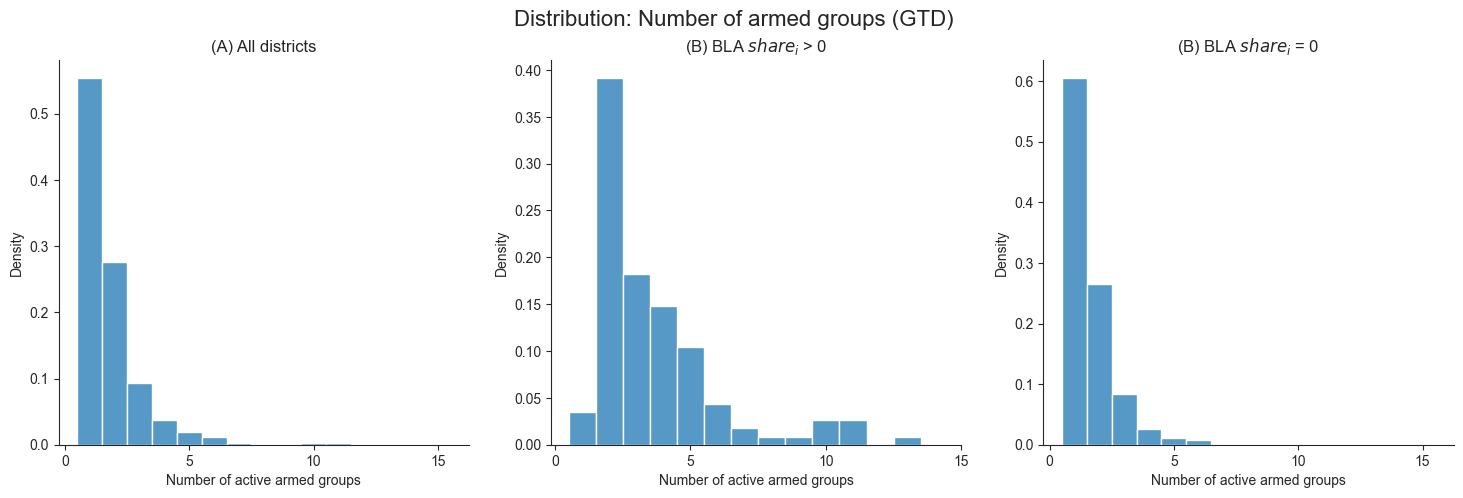

In [53]:
sns.set_style("ticks")
sns.set_palette("tab10")

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

condition = (gdf_final['number_groups']>0)
sns.histplot(data=gdf_final[condition], x="number_groups", stat="density", discrete=True, ax=ax[0])
ax[0].set_xlabel('Number of active armed groups')
ax[0].set_title('(A) All districts')
ax[0].set_xticks(range(0,16,5))

condition = (gdf_final['number_groups']>0) & (gdf_final['BLA_share']>0)
sns.histplot(data=gdf_final[condition], x="number_groups", stat="density", discrete=True, ax=ax[1])
ax[1].set_xlabel('Number of active armed groups')
ax[1].set_title('(B) BLA $share_i$ > 0')
ax[1].set_xticks(range(0,16,5))

condition = (gdf_final['number_groups']>0) & (gdf_final['BLA_share']==0)
sns.histplot(data=gdf_final[condition], x="number_groups", stat="density", discrete=True, ax=ax[2])
ax[2].set_xlabel('Number of active armed groups')
ax[2].set_title('(B) BLA $share_i$ = 0')
ax[2].set_xticks(range(0,16,5))

fig.suptitle('Distribution: Number of armed groups (GTD)', fontsize=16)
sns.despine()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/figure_a_1.png', bbox_inches='tight')
else:
    plt.tight_layout()

### Figure A-7 <a class="anchor" id="figure_a7"></a>

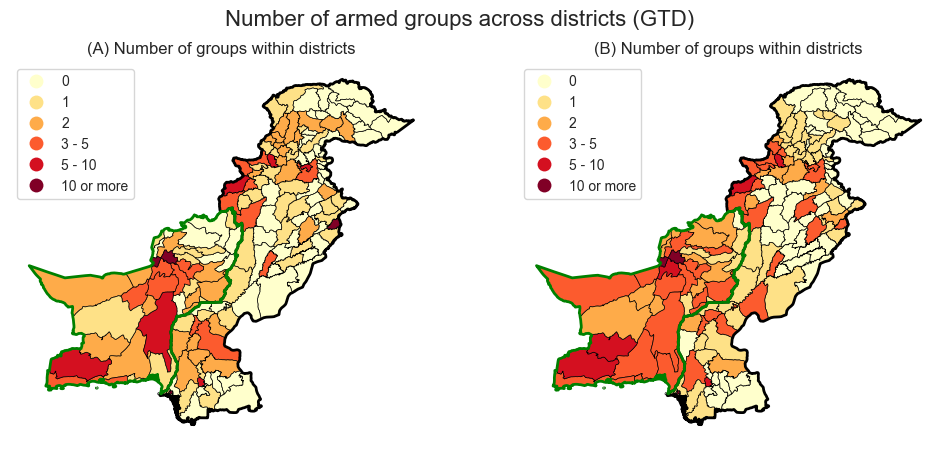

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

def remove_element(a):
    return set(a) - set(['', 'NA'])

# ----- (A) Number of groups within districts -----

ax[0].set_title('(A) Number of groups within districts')

condition = gdf_final.index.get_level_values(1) < 2014
gdf_plot = pd.DataFrame(gdf_final[condition].groupby(['ADM2_EN', 'geometry'])['groups_matched'].apply(sum).apply(set)).apply(
    lambda row: remove_element(row['groups_matched']), axis=1
).apply(len)
gdf_plot = gpd.GeoDataFrame(pd.DataFrame(gdf_plot).reset_index(), geometry=pd.DataFrame(gdf_plot).reset_index().geometry)
gdf_plot.rename(columns={0: 'number_groups'}, inplace=True)

gdf_plot.plot(column='number_groups', cmap='YlOrRd', scheme="User_Defined", 
         legend=True, classification_kwds=dict(bins=[0,1,2,5,10]), 
         legend_kwds=dict(loc= "upper left", labels=['0', '1', '2', '3 - 5', '5 - 10', '10 or more']),
         edgecolor="black", linewidth=.5, ax=ax[0])

#gdf_plot[gdf_plot['number_groups']==0].plot(column='number_groups', color='grey', edgecolor="black", linewidth=.5, ax=ax[0])

condition = gdf_pakistan['ADM1_EN'] == 'Balochistan'
gdf_pakistan[~condition].dissolve('ADM0_EN').plot(facecolor='none', edgecolor="black", linewidth=2, ax=ax[0])
gdf_pakistan[condition].dissolve('ADM1_EN').plot(facecolor='none', edgecolor="green", linewidth=2, ax=ax[0])
ax[0].set_axis_off()

# ----- (B) Number of groups within districts -----

ax[1].set_title('(B) Number of groups within districts')

condition = gdf_final.index.get_level_values(1) >= 2014
gdf_plot = pd.DataFrame(gdf_final[condition].groupby(['ADM2_EN', 'geometry'])['groups_matched'].apply(sum).apply(set)).apply(
    lambda row: remove_element(row['groups_matched']), axis=1
).apply(len)
gdf_plot = gpd.GeoDataFrame(pd.DataFrame(gdf_plot).reset_index(), geometry=pd.DataFrame(gdf_plot).reset_index().geometry)
gdf_plot.rename(columns={0: 'number_groups'}, inplace=True)

gdf_plot.plot(column='number_groups', cmap='YlOrRd', scheme="User_Defined", 
         legend=True, classification_kwds=dict(bins=[0,1,2,5,10]), 
         legend_kwds=dict(loc= "upper left", labels=['0', '1', '2', '3 - 5', '5 - 10', '10 or more']),
         edgecolor="black", linewidth=.5, ax=ax[1])

condition = gdf_pakistan['ADM1_EN'] == 'Balochistan'
gdf_pakistan[~condition].dissolve('ADM0_EN').plot(facecolor='none', edgecolor="black", linewidth=2, ax=ax[1])
gdf_pakistan[condition].dissolve('ADM1_EN').plot(facecolor='none', edgecolor="green", linewidth=2, ax=ax[1])

ax[1].set_axis_off()

fig.suptitle('Number of armed groups across districts (GTD)', fontsize=16)

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/figure_a_7.png', bbox_inches='tight')
else:
    plt.tight_layout()

### Figure A-8 <a class="anchor" id="figure_a8"></a>

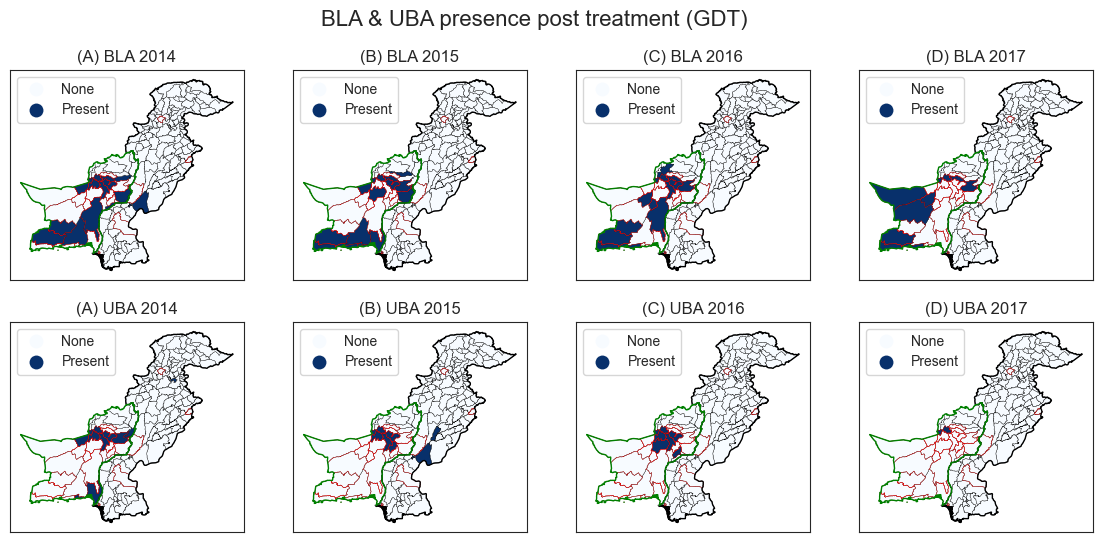

In [55]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

condition = gdf_final.index.get_level_values(1) < 2014
gdf_plot_pre = gdf_final[condition].groupby(['ADM2_EN', 'geometry'])['BLA_present'].max().reset_index()
gdf_plot_pre = gpd.GeoDataFrame(gdf_plot_pre, geometry=gdf_plot.geometry)

# ----- BLA -----

titles = ['(A) BLA 2014', '(B) BLA 2015', '(C) BLA 2016', '(D) BLA 2017']
years = [2014, 2015, 2016, 2017]
numbers = [0, 1, 2, 3]

for title, year, number in zip(titles, years, numbers):
    ax[0,number].set_title(title)

    condition = gdf_final.index.get_level_values(1) == year
    gdf_plot = gdf_final[condition].groupby(['ADM2_EN', 'geometry'])['BLA_present'].max().reset_index()
    gdf_plot = gpd.GeoDataFrame(gdf_plot, geometry=gdf_plot.geometry)

    gdf_plot.plot(column='BLA_present', cmap='Blues', categorical=True, legend=True, 
                  legend_kwds=dict(loc= "upper left", labels=['None', 'Present']),
                  edgecolor="black", linewidth=.25, ax=ax[0,number])

    gdf_plot_pre[gdf_plot_pre['BLA_present']==1].plot(column='BLA_present',facecolor='none', edgecolor="red", linewidth=.25, ax=ax[0,number])

    condition = gdf_pakistan['ADM1_EN'] == 'Balochistan'
    gdf_pakistan[~condition].dissolve('ADM0_EN').plot(facecolor='none', edgecolor="black", linewidth=1, ax=ax[0,number])
    gdf_pakistan[condition].dissolve('ADM1_EN').plot(facecolor='none', edgecolor="green", linewidth=1, ax=ax[0,number])
    ax[0,number].set_yticks([])
    ax[0,number].set_xticks([])

# ----- UBA -----

titles = ['(A) UBA 2014', '(B) UBA 2015', '(C) UBA 2016', '(D) UBA 2017']
years = [2014, 2015, 2016, 2017]
numbers = [0, 1, 2, 3]

for title, year, number in zip(titles, years, numbers):
    ax[1,number].set_title(title)

    condition = gdf_final.index.get_level_values(1) == year
    gdf_plot = gdf_final[condition].groupby(['ADM2_EN', 'geometry'])['UBA_present'].max().reset_index()
    gdf_plot = gpd.GeoDataFrame(gdf_plot, geometry=gdf_plot.geometry)

    gdf_plot.plot(column='UBA_present', cmap='Blues', categorical=True, legend=True, 
                  legend_kwds=dict(loc= "upper left", labels=['None', 'Present']),
                  edgecolor="black", linewidth=.25, ax=ax[1,number])

    gdf_plot_pre[gdf_plot_pre['BLA_present']==1].plot(column='BLA_present',facecolor='none', edgecolor="red", linewidth=.25, ax=ax[1,number])

    condition = gdf_pakistan['ADM1_EN'] == 'Balochistan'
    gdf_pakistan[~condition].dissolve('ADM0_EN').plot(facecolor='none', edgecolor="black", linewidth=1, ax=ax[1,number])
    gdf_pakistan[condition].dissolve('ADM1_EN').plot(facecolor='none', edgecolor="green", linewidth=1, ax=ax[1,number])
    ax[1,number].set_yticks([])
    ax[1,number].set_xticks([])

# ----- ----- -----

fig.suptitle('BLA & UBA presence post treatment (GDT)', fontsize=16)

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/figure_a_8.png', bbox_inches='tight')
else:
    plt.tight_layout()

### Figure 2 <a class="anchor" id="figure_2"></a>

In [56]:
## Country-Year dataframe: aggregated incidents and casualties
condition_year = (df_gtd['iyear'] >= 1995) & (df_gtd['iyear'] <= 2018)
df_gtd['casualties'] = df_gtd[['nkill', 'nwound']].sum(axis=1)
df_gtd['incidents'] = 1

gdf_plot = df_gtd[condition_year].groupby(['country_txt', 'iyear'])[['incidents', 'casualties']].sum()

## Country-Year dataframe: number of active armed groups
df_gtd['gname_combined'] = df_gtd.apply(lambda row: [row['gname']] + [row['gname2']] + [row['gname3']], axis=1) 

def remove_element(a):
    return set(a) - set(['', np.nan, 'Unknown'])

gdf_plot['groups'] = pd.DataFrame(
    df_gtd[condition_year].groupby(['country_txt', 'iyear'])['gname_combined'].apply(sum).apply(set)
).apply(lambda row: remove_element(row['gname_combined']), axis=1).apply(len)

In [57]:
## Log transformation
gdf_plot['Ln_incidents'] = np.log(gdf_plot['incidents'] + 1)
gdf_plot['Ln_casualties'] = np.log(gdf_plot['casualties'] + 1)
gdf_plot['Ln_groups'] = np.log(gdf_plot['groups'] + 1)

## Demeaning
gdf_plot['Ln_incidents_demeaned'] = gdf_plot['Ln_incidents'] - gdf_plot.groupby('country_txt')['Ln_incidents'].transform('mean') - gdf_plot.groupby('iyear')['Ln_incidents'].transform('mean')
gdf_plot['Ln_casualties_demeaned'] = gdf_plot['Ln_casualties'] - gdf_plot.groupby('country_txt')['Ln_casualties'].transform('mean') - gdf_plot.groupby('iyear')['Ln_casualties'].transform('mean')
gdf_plot['Ln_groups_demeaned'] = gdf_plot['Ln_groups'] - gdf_plot.groupby('country_txt')['Ln_groups'].transform('mean') - gdf_plot.groupby('iyear')['Ln_groups'].transform('mean')

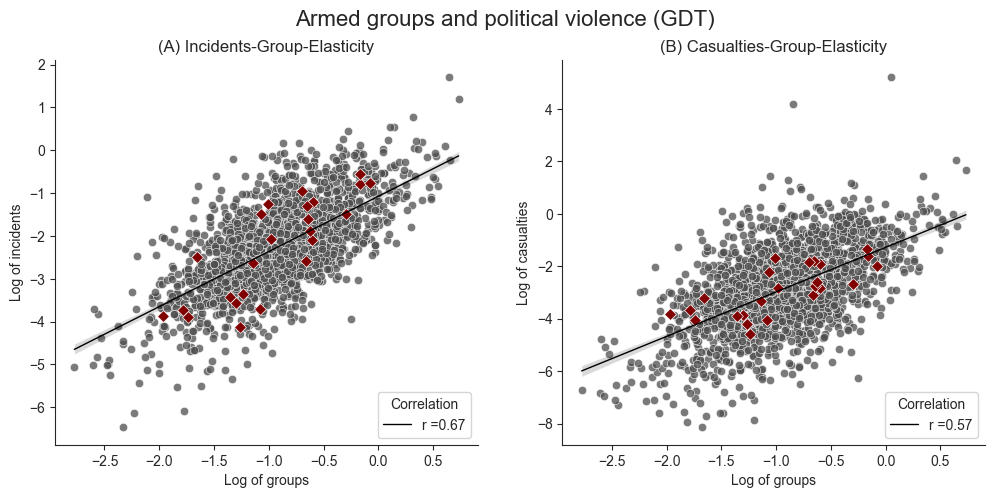

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=gdf_plot, x="Ln_groups_demeaned", y="Ln_incidents_demeaned", 
                marker="o", color=".3", alpha=0.75, ax=ax[0])

correlation_r = gdf_plot[['Ln_groups_demeaned', 'Ln_incidents_demeaned']].corr(method='pearson').iloc[0,1].round(2)
sns.regplot(data=gdf_plot, x="Ln_groups_demeaned", y="Ln_incidents_demeaned", label="r ={:.2f}".format(correlation_r),
            marker="o", color=".3", scatter=False, line_kws=dict(color="black", linewidth=1), order=1, ax=ax[0])

condition_country = gdf_plot.index.get_level_values(0) == 'Pakistan'
sns.scatterplot(data=gdf_plot[condition_country], x="Ln_groups_demeaned", y="Ln_incidents_demeaned", 
                marker="D", color="maroon", alpha=1, ax=ax[0])

# ----- ----- ----- -----

sns.scatterplot(data=gdf_plot, x="Ln_groups_demeaned", y="Ln_casualties_demeaned", 
                marker="o", color=".3", alpha=0.75, ax=ax[1])

correlation_r = gdf_plot[['Ln_groups_demeaned', 'Ln_casualties_demeaned']].corr(method='pearson').iloc[0,1].round(2)
sns.regplot(data=gdf_plot, x="Ln_groups_demeaned", y="Ln_casualties_demeaned", label="r ={:.2f}".format(correlation_r),
            ax=ax[1], marker="o", color=".3", scatter=False, line_kws=dict(color="black", linewidth=1), order=1)

condition_country = gdf_plot.index.get_level_values(0) == 'Pakistan'
sns.scatterplot(data=gdf_plot[condition_country], x="Ln_groups_demeaned", y="Ln_casualties_demeaned", 
                marker="D", color="maroon", alpha=1, ax=ax[1])

# ----- ----- ----- -----

ax[0].set_title("(A) Incidents-Group-Elasticity")
ax[0].set_ylabel("Log of incidents")
ax[0].set_xlabel("Log of groups")

ax[1].set_title("(B) Casualties-Group-Elasticity")
ax[1].set_ylabel("Log of casualties")
ax[1].set_xlabel("Log of groups")

ax[0].legend(title='Correlation', loc='lower right')
ax[1].legend(title='Correlation', loc='lower right')

fig.suptitle('Armed groups and political violence (GDT)', fontsize=16)

sns.despine()

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/figure_2.png', bbox_inches='tight')
else:
    plt.tight_layout()

### Figure 3 <a class="anchor" id="figure_3"></a>

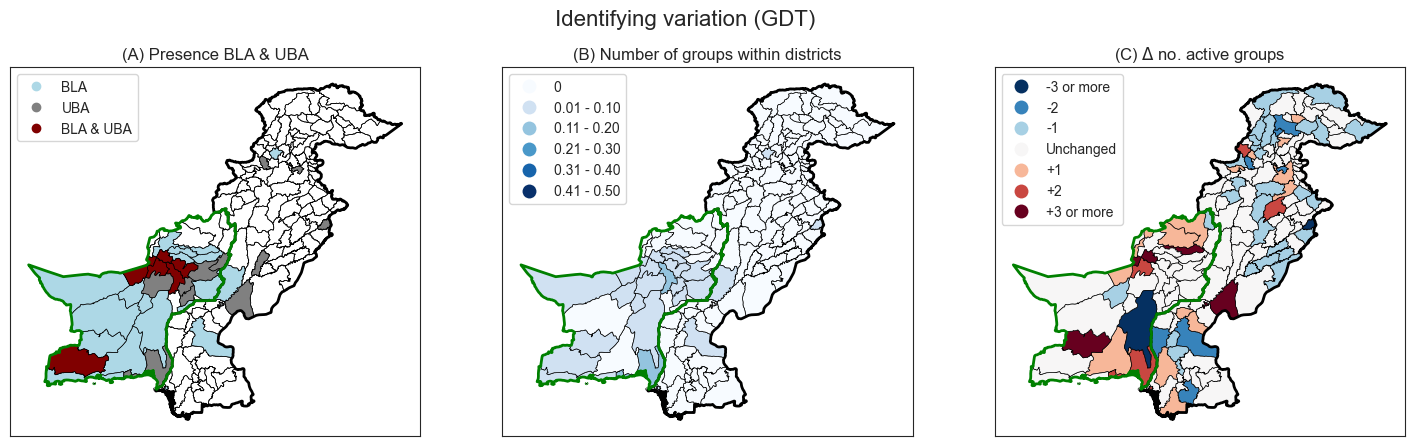

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# ----- (A) Presence BLA & UBA -----

gdf_plot = gdf_final.groupby(['ADM2_EN', 'geometry'])[['BLA_present', 'UBA_present', 'BLA_UBA_present']].max().reset_index()
gdf_plot = gpd.GeoDataFrame(gdf_plot, geometry=gdf_plot.geometry)

ax[0].set_title('(A) Presence BLA & UBA')

gdf_pakistan.plot(facecolor='none', edgecolor="black", linewidth=.5, ax=ax[0])

gdf_plot[gdf_plot['BLA_present'] == 1].plot(color='Lightblue', edgecolor='black', linewidth=.5, ax=ax[0])
gdf_plot[gdf_plot['UBA_present'] == 1].plot(color='Grey', edgecolor='black', linewidth=.5, ax=ax[0])
gdf_plot[gdf_plot['BLA_UBA_present'] == 1].plot(color='Maroon', edgecolor='black', linewidth=.5, ax=ax[0])

condition = gdf_pakistan['ADM1_EN'] == 'Balochistan'
gdf_pakistan[~condition].dissolve('ADM0_EN').plot(facecolor='none', edgecolor="black", linewidth=2, ax=ax[0])
gdf_pakistan[condition].dissolve('ADM1_EN').plot(facecolor='none', edgecolor="green", linewidth=2, ax=ax[0])

ax[0].set_yticks([])
ax[0].set_xticks([])

ax[0].legend([lines.Line2D([0], [0], marker='o', ls='', c='Lightblue'),
           lines.Line2D([0], [0], marker='o', ls='', c='Grey'),
           lines.Line2D([0], [0], marker='o', ls='', c='Maroon')],
          ['BLA', 'UBA', 'BLA & UBA'], loc='upper left')

# ----- (B) Number of groups within districts -----

gdf_plot = gdf_final[gdf_final.index.get_level_values(1) < 2014].groupby(['ADM2_EN', 'geometry'])[['BLA_share']].mean().reset_index()
gdf_plot = gpd.GeoDataFrame(gdf_plot, geometry=gdf_plot.geometry)

ax[1].set_title('(B) Number of groups within districts')

gdf_plot.plot(column='BLA_share', cmap='Blues', scheme="User_Defined", 
         legend=True, classification_kwds=dict(bins=[0,0.1,0.2,0.3,0.4,0.5]), 
         legend_kwds=dict(loc= "upper left", labels=['0', '0.01 - 0.10', '0.11 - 0.20', '0.21 - 0.30', '0.31 - 0.40', '0.41 - 0.50']),
         edgecolor="black", linewidth=.5, ax=ax[1])

condition = gdf_pakistan['ADM1_EN'] == 'Balochistan'
gdf_pakistan[~condition].dissolve('ADM0_EN').plot(facecolor='none', edgecolor="black", linewidth=2, ax=ax[1])
gdf_pakistan[condition].dissolve('ADM1_EN').plot(facecolor='none', edgecolor="green", linewidth=2, ax=ax[1])

ax[1].set_yticks([])
ax[1].set_xticks([])

# ----- (C) Delta no. active groups -----

condition = gdf_final.index.get_level_values(1) < 2014
gdf_plot1 = pd.DataFrame(gdf_final[condition].groupby(['ADM2_EN', 'geometry'])['groups_matched'].apply(sum).apply(set)).apply(
    lambda row: remove_element(row['groups_matched']), axis=1
).apply(len)
condition = gdf_final.index.get_level_values(1) >= 2014
gdf_plot2 = pd.DataFrame(gdf_final[condition].groupby(['ADM2_EN', 'geometry'])['groups_matched'].apply(sum).apply(set)).apply(
    lambda row: remove_element(row['groups_matched']), axis=1
).apply(len)
gdf_plot = (gdf_plot2 - gdf_plot1).reset_index()
gdf_plot = gpd.GeoDataFrame(gdf_plot, geometry=gdf_plot.geometry)
gdf_plot.rename(columns={0: 'delta_groups'}, inplace=True)

ax[2].set_title('(C) $\Delta$ no. active groups')

gdf_plot.plot(column='delta_groups', cmap='RdBu_r', scheme="User_Defined", 
         legend=True, classification_kwds=dict(bins=[-3,-2,-1,1,2,3]), 
         legend_kwds=dict(loc= "upper left", labels=['-3 or more', '-2', '-1', 'Unchanged', '+1', '+2', '+3 or more']),
         edgecolor="black", linewidth=.5, ax=ax[2])

condition = gdf_pakistan['ADM1_EN'] == 'Balochistan'
gdf_pakistan[~condition].dissolve('ADM0_EN').plot(facecolor='none', edgecolor="black", linewidth=2, ax=ax[2])
gdf_pakistan[condition].dissolve('ADM1_EN').plot(facecolor='none', edgecolor="green", linewidth=2, ax=ax[2])

ax[2].set_yticks([])
ax[2].set_xticks([])

fig.suptitle('Identifying variation (GDT)', fontsize=16)

if savefigures:
    plt.savefig(f'{ROOT_FOLDER}/output/figure_3.png', bbox_inches='tight')
else:
    plt.tight_layout()

---

## Next Steps <a class="anchor" id="next_steps"></a>

- Explore variation in the method of attacks

---